### Notes for Harry - v2
#### by August George, 2022

* ref on Julia SciML framework: https://si.sciml.ai/dev/ 
* ref on global sensitivity module: https://diffeq.sciml.ai/stable/analysis/global_sensitivity/ 
* ref on parameter identifiability module: https://mtk.sciml.ai/stable/tutorials/parameter_identifiability/ 
* ref on transporter modeling: https://journals.plos.org/ploscompbiol/article/authors?id=10.1371/journal.pcbi.1007884

### import packages and set random seed

In [1]:
using Catalyst, DifferentialEquations, StructuralIdentifiability, ModelingToolkit, DiffEqSensitivity, Plots, QuasiMonteCarlo,  Noise, Random
using ModelingToolkit: varmap_to_vars
Random.seed!(14)

Singular.jl, based on
                     SINGULAR                               /
 A Computer Algebra System for Polynomial Computations     /  Singular.jl: 0.5.7
                                                         0<   Singular   : 4.2.0p1
 by: W. Decker, G.-M. Greuel, G. Pfister, H. Schoenemann   \
FB Mathematik der Universitaet, D-67653 Kaiserslautern      \
     


TaskLocalRNG()

## section 1: parameter identifiability analysis

In [2]:
### define reaction network in Catalyst
# notes: 
# H = H+/ion, S = substrate
# 'OF' = outward facing conformation, 'IF' = inward facing conformation
# 'H_out' and 'S_out' = fixed external concentrations of the ion and substrate, respectively
# 'H_in' and 'S_in' = internal concentrations of the ion and substrate, respectively
# 'Hb' and 'Sb' are the ion and/or substrate bound to the protein, respectively

# single antiporter pathway (ion and substrate transported in opposite directions)
rn = @reaction_network begin
  (k1_f*H_out, k1_r), OF <--> OF_Hb
  (k2_f, k2_r), OF_Hb <--> IF_Hb
  (k3_f, k3_r), IF_Hb + S_in <--> IF_Hb_Sb
  (k4_f, k4_r), IF_Hb_Sb <--> IF_Sb + H_in
  (k5_f, k5_r), IF_Sb <--> OF_Sb
  (k6_f, k6_r*S_out), OF_Sb <--> OF
end H_out S_out k1_f k1_r k2_f k2_r k3_f k3_r k4_f k4_r k5_f k5_r k6_f k6_r

Model ##ReactionSystem#327 with 12 equations
States (8):
  OF(t)
  OF_Hb(t)
  IF_Hb(t)
  S_in(t)
  IF_Hb_Sb(t)
  IF_Sb(t)
⋮
Parameters (14):
  H_out
  S_out
  k1_f
  k1_r
  k2_f
  k2_r
⋮

In [3]:
### latexify
odesys = convert(ODESystem, rn)
equations(odesys)

8-element Vector{Equation}:
 Differential(t)(OF(t)) ~ k1_r*OF_Hb(t) + k6_f*OF_Sb(t) - H_out*k1_f*OF(t) - S_out*k6_r*OF(t)
 Differential(t)(OF_Hb(t)) ~ k2_r*IF_Hb(t) + H_out*k1_f*OF(t) - k1_r*OF_Hb(t) - k2_f*OF_Hb(t)
 Differential(t)(IF_Hb(t)) ~ k3_r*IF_Hb_Sb(t) + k2_f*OF_Hb(t) - k2_r*IF_Hb(t) - k3_f*IF_Hb(t)*S_in(t)
 Differential(t)(S_in(t)) ~ k3_r*IF_Hb_Sb(t) - k3_f*IF_Hb(t)*S_in(t)
 Differential(t)(IF_Hb_Sb(t)) ~ k3_f*IF_Hb(t)*S_in(t) + k4_r*H_in(t)*IF_Sb(t) - k3_r*IF_Hb_Sb(t) - k4_f*IF_Hb_Sb(t)
 Differential(t)(IF_Sb(t)) ~ k4_f*IF_Hb_Sb(t) + k5_r*OF_Sb(t) - k5_f*IF_Sb(t) - k4_r*H_in(t)*IF_Sb(t)
 Differential(t)(H_in(t)) ~ k4_f*IF_Hb_Sb(t) - k4_r*H_in(t)*IF_Sb(t)
 Differential(t)(OF_Sb(t)) ~ k5_f*IF_Sb(t) + S_out*k6_r*OF(t) - k5_r*OF_Sb(t) - k6_f*OF_Sb(t)

In [4]:
# make ODE model w/ 3 obersved quantities (H_out, S_out, and dH_in/dt)
rn_ode = @ODEmodel(
    OF'(t) = k1_r*OF_Hb(t)+k6_f*OF_Sb(t)−H_out*k1_f*OF(t)−S_out*k6_r*OF(t),
    OF_Hb'(t) = k2_r*IF_Hb(t)+H_out*k1_f*OF(t)−k1_r*OF_Hb(t)−k2_f*OF_Hb(t),
    IF_Hb'(t) = k3_r*IF_Hb_Sb(t)+k2_f*OF_Hb(t)−k2_r*IF_Hb(t)−k3_f*IF_Hb(t)*S_in(t),
    S_in'(t) = k3_r*IF_Hb_Sb(t)−k3_f*IF_Hb(t)*S_in(t),
    IF_Hb_Sb'(t) = −k3_r*IF_Hb_Sb(t)−k4_f*IF_Hb_Sb(t)+k3_f*IF_Hb(t)*S_in(t)+k4_r*H_in(t)*IF_Sb(t),
    IF_Sb'(t) = k4_f*IF_Hb_Sb(t)+k5_r*OF_Sb(t)−k5_f*IF_Sb(t)−k4_r*H_in(t)*IF_Sb(t),
    H_in'(t) = k4_f*IF_Hb_Sb(t)−k4_r*H_in(t)*IF_Sb(t),
    OF_Sb'(t) = k5_f*IF_Sb(t)+S_out*k6_r*OF(t)−k5_r*OF_Sb(t)−k6_f*OF_Sb(t), 
    
    y1(t) = H_out, 
    y2(t) = S_out, 
    y3(t) = H_in'(t)
)

# run local identifiability w/ 99% probability
@time local_id = assess_local_identifiability(rn_ode, 0.99)
println(local_id)

# # run global identifiability w/ 99% probability (might be really slow)
# @time global_id = assess_global_identifiability(rn_ode, 0.99)
# println(global_id)

 12.738972 seconds (30.56 M allocations: 2.027 GiB, 4.40% gc time, 97.21% compilation time)
Dict{Nemo.fmpq_mpoly, Bool}(IF_Sb => 1, S_in => 1, S_out => 1, k3_f => 1, k1_f => 1, k6_f => 1, k2_f => 1, k4_f => 1, H_out => 1, k1_r => 1, OF_Hb => 1, IF_Hb => 1, k5_f => 1, k3_r => 1, k2_r => 1, H_in => 1, OF_Sb => 1, OF => 1, k6_r => 1, k4_r => 1, k5_r => 1, IF_Hb_Sb => 1)


┌ Info: Summary of the model:
└ @ StructuralIdentifiability /Users/georgeau/.julia/packages/StructuralIdentifiability/EQH60/src/ODE.jl:303
┌ Info: State variables: S_in, IF_Hb_Sb, OF, H_in, IF_Hb, OF_Sb, IF_Sb, OF_Hb
└ @ StructuralIdentifiability /Users/georgeau/.julia/packages/StructuralIdentifiability/EQH60/src/ODE.jl:304
┌ Info: Parameters: k2_f, k5_f, k4_r, S_out, k3_r, k3_f, k4_f, k5_r, k1_f, H_out, k6_f, k1_r, k6_r, k2_r
└ @ StructuralIdentifiability /Users/georgeau/.julia/packages/StructuralIdentifiability/EQH60/src/ODE.jl:305
┌ Info: Inputs: 
└ @ StructuralIdentifiability /Users/georgeau/.julia/packages/StructuralIdentifiability/EQH60/src/ODE.jl:306
┌ Info: Outputs: y3, y1, y2
└ @ StructuralIdentifiability /Users/georgeau/.julia/packages/StructuralIdentifiability/EQH60/src/ODE.jl:307


## section 2: parameter sensitivity analysis

log-likelihood (ref): 10735.067359024282


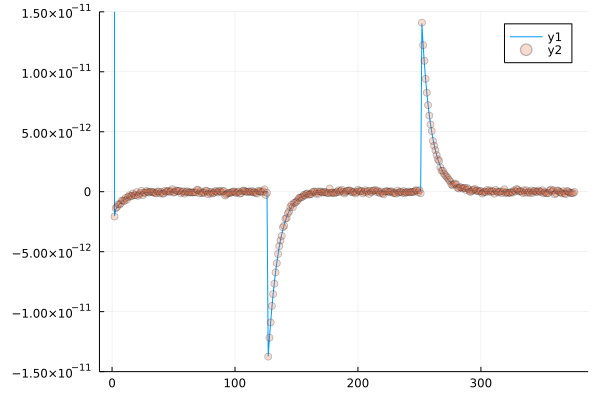

In [5]:

# flux calculation: flux = d H_in / dt = k4_f * IF_Hb_Sb(t) − k4_r * H_in(t) * IF_Sb(t)
function calc_flux(p,u,v)
    flux_in = v*(p[1]*u[1])
    flux_out = v*(p[2]*u[2].*u[3])
    net_flux = flux_in - flux_out         
end


# Normal log-likelihood calculation
function calc_norm_log_likelihood(mu,sigma,X)
    # Normal log-likelihood function: -[(n/2)ln(2pp*sigma^2)]-[sum((X-mu)^2)/(2*sigma^2)]
    # ref: https://www.statlect.com/fundamentals-of-statistics/normal-distribution-maximum-likelihood 
    n = length(X)
    f1 = -1*(n/2)*log(2*pi*sigma^2)
    f2_a = -1/(2*sigma^2)
    f2_b = 0 
    for i in 1:n
        f2_b += (X[i]-mu[i])^2
    end
    f2 = f2_a*f2_b
    log_likelihood = f1+f2
end


# define initial variable values and parameters
H_out_ref = 1e-7
S_out_ref = 1e-3
stdev_ref = 1e-13
@parameters  H_out S_out k1_f k1_r k2_f k2_r k3_f k3_r k4_f k4_r k5_f k5_r k6_f k6_r 
@variables t H_in(t) S_in(t) OF(t) OF_Hb(t) IF_Hb(t) IF_Hb_Sb(t) IF_Sb(t) OF_Sb(t)
u0map = [H_in => 1e-7, S_in => 1e-3, 
        OF => 2.833e-8, OF_Hb => 2.833e-8,  
        IF_Hb => 2.833e-8, IF_Hb_Sb => 2.833e-8,
        IF_Sb => 2.125e-8, OF_Sb => 2.125e-8, 
]
pmap = [H_out => H_out_ref, S_out => S_out_ref,
        k1_f =>1e10, k1_r =>1e3,
        k2_f =>1e2, k2_r =>1e2,
        k3_f =>1e7, k3_r =>1e3,
        k4_f =>1e3, k4_r =>1e10,
        k5_f =>1e2, k5_r =>1e2,
        k6_f =>1e3, k6_r =>1e7
]


# set ODE integrator tolerance and time span
atol = 1e-18  
rtol = 1e-12
t_sample = 0.04
tspan = (0.0,15)
event_times = [5.0,10.0]

# create ODEproblem w/ timed events discrete callback
# changes H_out concentration at t=5 and t=10
oprob = ODEProblem(odesys, u0map, tspan, pmap)
condition(u,t,integrator) = t ∈ event_times
function affect!(integrator)
    if integrator.t == 5.0
        integrator.p[1] = 5e-8
    elseif integrator.t == 10.0
        integrator.p[1] = 1e-7
    end
end
cb = DiscreteCallback(condition,save_positions=(false, false), affect!)

# solve ODEs using TRBDF2 solver (ODE integrator for stiff systems)
sol = solve(oprob, TRBDF2(), abstol = atol, reltol = rtol, saveat=t_sample, callback=cb, tstops=event_times)

# calculate flux = vol * d H_in / dt = vol * (k4_f * IF_Hb_Sb(t) − k4_r * H_in(t) * IF_Sb(t))
k_true = [pmap[9][2], pmap[10][2]]  # k4_f, k4_r
c_true = [sol[IF_Hb_Sb], sol[H_in], sol[IF_Sb]]
vol = 0.0001
y_true = calc_flux(k_true,c_true,vol)
y_obs = add_gauss(y_true,stdev_ref)  # add Gaussian noise to data to make synthetic data
log_likelihood_ref = calc_norm_log_likelihood(y_obs, stdev_ref, y_true)

println("log-likelihood (ref): $log_likelihood_ref")
plot(y_true, ylim=(-1.5e-11, 1.5e-11));scatter!(y_obs, alpha=0.25)



In [6]:
# create function for senstivity analysis that inputs a set of parameters and returns a scalar or vector value
# using log10 space for parameters
function f1(p)
    sigma_tmp = 10.0^p[12]
    log_k6_r = (p[1]+p[3]+p[5]+p[7]+p[9]+p[11]) - (p[2]+p[4]+p[6]+p[8]+p[10])
    pmap2 = [H_out => H_out_ref, S_out => S_out_ref,
            k1_f =>10.0^p[1], k1_r =>10.0^p[2],
            k2_f =>10.0^p[3], k2_r =>10.0^p[4],
            k3_f =>10.0^p[5], k3_r =>10.0^p[6],
            k4_f =>10.0^p[7], k4_r =>10.0^p[8],
            k5_f =>10.0^p[9], k5_r =>10.0^p[10],
            k6_f =>10.0^p[11], k6_r =>10.0^log_k6_r,
    ]
    # solve ODE system
    pnew2 = varmap_to_vars(pmap2, parameters(odesys))
    oprob2 = remake(oprob, p=pnew2)
    sol2 = solve(oprob2, TRBDF2(), abstol = atol, reltol = rtol, saveat=0.04, callback=cb, tstops=event_times)
    
    # calc flux (y_pred)
    k2 = [pmap2[9][2], pmap2[10][2]]
    c2 = [sol2[IF_Hb_Sb], sol2[H_in], sol2[IF_Sb]]
    vol = 0.0001
    y_pred2 = calc_flux(k2,c2,vol)
    log_likelihood_tmp = calc_norm_log_likelihood(y_obs,sigma_tmp,y_pred2)  
    return log_likelihood_tmp
end

# test using log10 values of reference parameters
p_test =[
        10, 3,
        2, 2,
        7, 3,
        3, 10,
        2, 2,
        3,
        -13
]
log_likelihood_test = f1(p_test)
println("log-likelihood (test): $log_likelihood_test")  # should be same as previous cell

log-likelihood (test): 10735.067359024282


In [11]:
# Morris sensitivity analysis
p_range = [
    [6,12],[-1,5],
    [-2,4],[-2,4],
    [3,9],[-1,5],
    [-1,5],[6,12],
    [-2,4],[-2,4],
    [-1,5], 
    [log10(5e-14), log10(5e-13)]
]
sa = gsa(f1, Morris(total_num_trajectory=1000, num_trajectory=150), p_range, N=100)

println(sa.means)
println(sa.variances)


[-162.10703450518938 1634.6162240258193 -3822.5131965990295 2450.0751213360286 3341.629053866433 -4.102954209997055 -3.7611213595412915e11 -1.7771220450701132e11 1459.6510351249924 623.153070747515 3558.949503383738]
[4.766046346640024e6 5.9477956596258275e7 3.406284616926773e8 1.9640091596452758e8 8.41874226342425e8 2.7336335870163447e8 1.9558000247165093e24 9.027366859933119e23 2.246074323340432e8 5.624602707483569e7 5.876105790651867e8]


┌ Warning: Global Sensitivity Analysis has been moved to separate package GlobalSensitivity.jl (https://github.com/SciML/GlobalSensitivity.jl)
└ @ DiffEqSensitivity /Users/georgeau/.julia/packages/DiffEqSensitivity/T7LDZ/src/DiffEqSensitivity.jl:75


In [8]:
# Sobol sensitivity analysis
N = 1000
lb = [6,-1,-2,-2,3,-1,-1,6,-2,-2,-1,log10(5e-14)]
ub = [12,5,4,4,9,5,5,12,4,4,5,log10(5e-13)]
sampler = SobolSample()
A,B = QuasiMonteCarlo.generate_design_matrices(N,lb,ub,sampler)
sobol_result = gsa(f1,Sobol(),A,B)

┌ Warning: Global Sensitivity Analysis has been moved to separate package GlobalSensitivity.jl (https://github.com/SciML/GlobalSensitivity.jl)
└ @ DiffEqSensitivity /Users/georgeau/.julia/packages/DiffEqSensitivity/T7LDZ/src/DiffEqSensitivity.jl:75


GlobalSensitivity.SobolResult{Vector{Float64}, Nothing, Nothing, Nothing}([-5.022550391969768e-10, 1.2910476299265908e-9, -2.887570328471562e-10, -6.247407525686601e-10, 4.522654617165092e-9, 1.3746369540131195e-9, 0.3389604539468475, 0.06067150466261658, 3.310358449269781e-9, 2.1739002176661296e-9, -9.551863293470791e-10, 0.07715660809707027], nothing, nothing, nothing, [4.72707097699588e-10, -3.38456474148972e-9, -4.1713072474503705e-9, 4.6985968434523056e-9, -2.365391281717153e-9, 1.6109499086083378e-9, 0.5542163750668164, 0.2308918656645281, 4.146030704095498e-9, 5.13046766682765e-9, 4.648052570015535e-10, 0.3849029842907319], nothing)

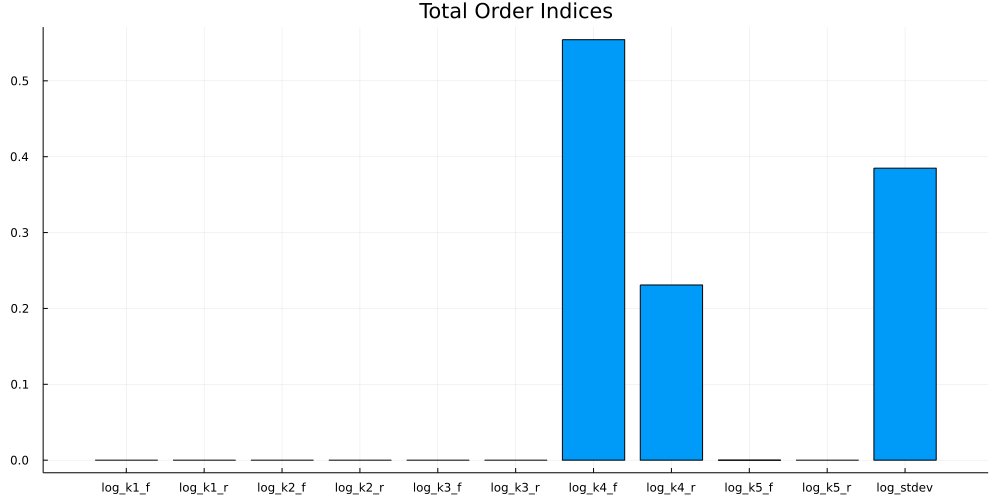

In [9]:
# plot 'total order index' results 
# i.e. how much individual parameters + parameter combinations contribute to output variation
p_labels = [
            "log_k1_f", "log_k1_r",
            "log_k2_f", "log_k2_r",
            "log_k3_f", "log_k3_r",
            "log_k4_f", "log_k4_r",
            "log_k5_f", "log_k5_r",
            "log_k5_f", "log_stdev"
]
p1 = bar(p_labels,sobol_result.ST[:],title="Total Order Indices",legend=false)
plot(p1)
plot!(size=(1000,500))

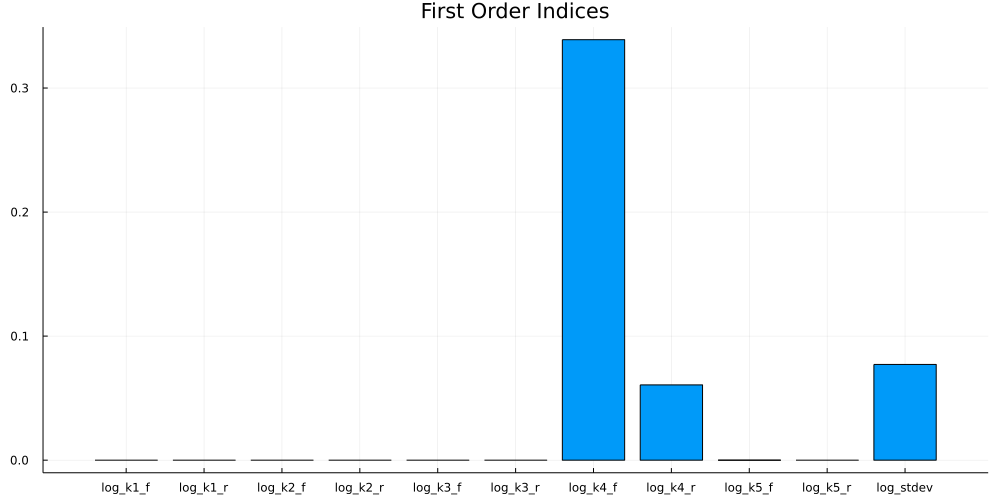

In [10]:
# plot 'first order index' results
# i.e. how much individual parameters contribute to output variation
p2 = bar(p_labels,sobol_result.S1[:],title="First Order Indices",legend=false)
plot(p2)
plot!(size=(1000,500))